In [1]:
import sys
sys.path.append('..')
import shapSD as ssd
import pandas as pd
#Display all content in dataframe
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


### Load house dataset

In [2]:
file_path = '../data/house_data.csv'
house = pd.read_csv(file_path)
house = house.drop(['id', 'date'], axis=1)
house.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900.0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000.0
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000.0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000.0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000.0


**drop highly correlated features**

In [3]:
fp = ssd.FeatureProcessing(house)
fp.show_corr_features(cut_off=0.7)

The following dataframe shows the correlated features in this dataset


spearmanr_corr
sqft_lot    sqft_lot15     0.9223        
sqft_living sqft_above     0.8435        
            sqft_living15  0.7470        
bathrooms   sqft_living    0.7455        
sqft_living grade          0.7164        
grade       sqft_above     0.7118

In [4]:
drop_feature = ['sqft_lot15', 'sqft_above', 'sqft_living15']
house = house.drop(drop_feature, axis=1)

### Show Feature Importance on dataset

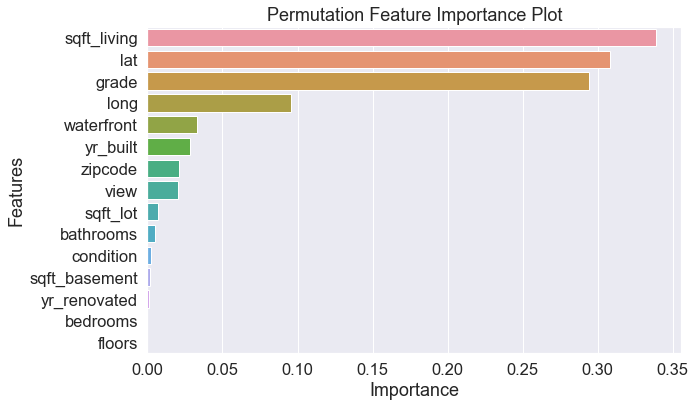

In [5]:
x_train, y_train = house.drop('price', axis=1), house['price']
# init lightgbm model
lgb_model = ssd.InitializeModel(x_train, y_train).lgb_reg_model()
# construct FeamtureImportance class, to visualize feature importance
feature_imp = ssd.FeatureImportance(x_train, y_train, lgb_model)
imp = feature_imp.permutation_importance()
feature_imp.vis_perm_importance(imp)

<font color='blue'>
    
According to 'Permutation Feature Importance plot', `sqft_living`, `lat` and `grade` are the most important features (from global interpretation view)

### Calculate Shapley values

In [6]:
tree_shap = ssd.ShapValues(x_train, lgb_model, explainer_type='Tree')

Saving figure summary_plot_1564477565


I0730 11:06:10.612985 4513043904 logging_custom.py:46] shap_summary_plot running time: 0M:9s:545ms


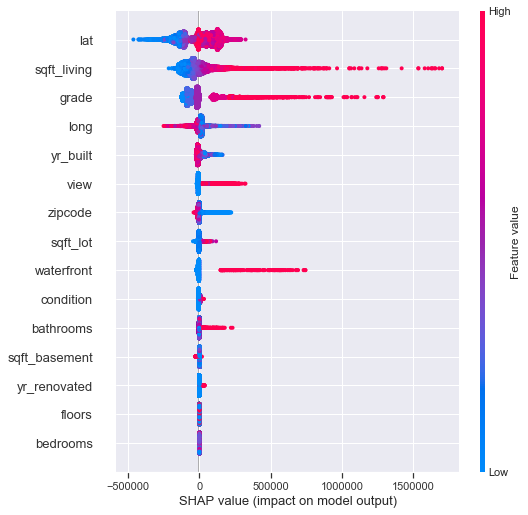

In [7]:
# show shap summary plot
tree_shap.shap_summary_plot()

<font color='blue'>
    
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot above sorts features by the sum of SHAP (absolute) value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

In general, feature `lat`, `sqft_living`, `grade` has large impact on predicting model results. 

Saving figure dependence_plot_grade_1564477578


I0730 11:06:19.440518 4513043904 logging_custom.py:46] shap_dependence_plot running time: 0M:3s:990ms


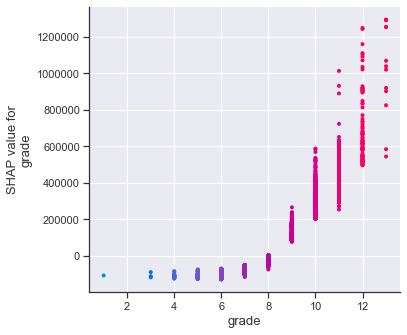

In [8]:
attr = 'grade'
tree_shap.shap_dependence_plot(ind=attr, interaction_index=attr)

<font color='blue'>
    
To understand how a single feature affects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot above represents the change in predicted house price as `grade` changes

Generally to say, higher `grade` value, higher predicted house price. 

### Exp1: Numeric variable perturbation

**grade perturbation**

In [9]:
perturb_attr = 'grade'
n_perturb = ssd.NumericPerturb(x_train, y_train, lgb_model, perturb_attr)
# effect of perturb "grade" value
df_perturb = n_perturb.calc_perturb_effect()
df_perturb.head()
ignore_attr = list(df_perturb.columns[-2:])
df_perturb_effect = pd.concat([house, df_perturb[ignore_attr]], axis=1)
df_perturb_effect.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price,grade_change,grade_prediction_change
0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,221900.0,1,88233.238606
1,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,538000.0,1,17884.391600
2,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,180000.0,2,132725.545573
3,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,604000.0,1,64443.396759
4,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,510000.0,1,31625.296377


<font color='blue'>
    
Calculate the `grade` effect(prediction change) when we shuffle the age value

The mean correlation of `grade_change` and `grade_prediction_change` is 0.77

In [10]:
# grade change and prediction change as the complext target
target = ssd.ComplexTarget((ignore_attr[0], ignore_attr[1]))
search_space = ssd.create_selectors(df_perturb_effect, ignore=[ignore_attr[0], ignore_attr[1], 'price', 'grade'])
task = ssd.SubgroupDiscoveryTask(df_perturb_effect, target, search_space, qf=ssd.CorrelationQF('entropy'), result_set_size=10)
result = ssd.BeamSearch().execute(task)
# result = ssd.overlap_filter(result, df_perturb_effect, similarity_level=0.85)
df_result = ssd.as_df(df_perturb_effect, result, statistics_to_show=ssd.complex_statistics, complex_target=True)
df_result

,quality,subgroup,sg_size,dataset_size,complement_sg_size,sg_corr,dataset_corr,complement_sg_corr,corr_lift
0,0.0664,floors: [1.0:1.50[ AND yr_renovated: [0:1934[ AND view=0,9346.0,21613.0,12267.0,0.831042,0.763737,0.763738,1.088125
1,0.0657,floors: [1.0:1.50[ AND view=0,9684.0,21613.0,11929.0,0.829906,0.763737,0.763738,1.086638
2,0.0657,floors: [1.0:1.50[ AND waterfront=0 AND view=0,9684.0,21613.0,11929.0,0.829906,0.763737,0.763738,1.086638
3,0.0593,floors: [1.0:1.50[ AND yr_renovated: [0:1934[ AND waterfront=0,10239.0,21613.0,11374.0,0.823168,0.763737,0.763738,1.077816
4,0.0589,floors: [1.0:1.50[ AND waterfront=0,10623.0,21613.0,10990.0,0.822602,0.763737,0.763738,1.077075
5,0.0581,floors: [1.0:1.50[ AND yr_renovated: [0:1934[,10284.0,21613.0,11329.0,0.821923,0.763737,0.763738,1.076186
6,0.0578,bedrooms: [3:4[ AND view=0 AND floors: [1.0:1.50[,5070.0,21613.0,16543.0,0.837220,0.763737,0.763738,1.096215
7,0.0576,bedrooms: [3:4[ AND floors: [1.0:1.50[ AND waterfront=0,5434.0,21613.0,16179.0,0.834591,0.763737,0.763738,1.092772
8,0.0574,bedrooms: [3:4[ AND floors: [1.0:1.50[,5455.0,21613.0,16158.0,0.834104,0.763737,0.763738,1.092136
9,0.0562,floors: [1.0:1.50[ AND yr_renovated: [0:1934[ AND bedrooms: [3:4[,5272.0,21613.0,16341.0,0.833862,0.763737,0.763738,1.091818


<font color='blue'>
    
The mean correlation of `grade_change` and `grade_prediction_change` in the overall dataset is 0.77 while in the subgroup `floors: [1.0:1.50[ AND view=0 AND yr_renovated: [0:1934[`, the mean correlation is 0.83 

In the subgroup `floors: [1.0:1.50[ AND view=0 AND yr_renovated: [0:1934[`, it is more **sensitive** to `grade change` because more grade changes cause more prediction changes. Therefore, in this subgroup, feature `grade` has more impact.

**grade increment by 3**

In [11]:
target_name = '{}_prediction_change'.format(perturb_attr)
df_grade_increment = n_perturb.calc_add_effect(add_value=3)
df_grade_increment = pd.concat([house, df_grade_increment[target_name]], axis=1)
df_grade_increment.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price,grade_prediction_change
0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,221900.0,485649.696513
1,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,538000.0,478096.233092
2,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,180000.0,391580.977341
3,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,604000.0,473513.948246
4,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,510000.0,192893.707416


In [12]:
def subgroup_discovery(df_effect, flip_attr, target_name, measure):
    target = ssd.NumericTarget(target_name)
    search_space = ssd.create_selectors(df_effect, ignore=[flip_attr, target_name, 'price'])
    task = ssd.SubgroupDiscoveryTask(df_effect, target, search_space, qf=measure, result_set_size=10)
    result = ssd.BeamSearch().execute(task)
#     result = spd.overlap_filter(result, df_effect, similarity_level=0.85)
    df_result = ssd.as_df(df_effect, result, statistics_to_show=ssd.all_statistics_numeric)
    return df_result[['quality', 'subgroup', 'size_sg', 'mean_sg', 'mean_dataset', 'mean_lift']]

In [13]:
df_grade_effect = subgroup_discovery(df_grade_increment, perturb_attr, target_name, ssd.IncrementalQFNumeric(1))
df_grade_effect

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,43008.588845,yr_built<1947 AND waterfront=0,4196.0,436104.095938,338493.945948,1.288366
1,42871.347602,yr_built<1947,4244.0,435240.827281,338493.945948,1.285816
2,41431.324197,zipcode: [98103:98125[ AND waterfront=0,4435.0,429955.700580,338493.945948,1.270202
3,41344.282980,yr_built<1947 AND view=0,3727.0,438055.873216,338493.945948,1.294132
4,41226.007898,zipcode: [98103:98125[,4444.0,429410.252375,338493.945948,1.268591
5,39787.277935,zipcode: [98103:98125[ AND view=0,3984.0,431164.570419,338493.945948,1.273773
6,39662.802627,yr_built<1947 AND yr_renovated: [0:1934[,3717.0,434135.064124,338493.945948,1.282549
7,39372.178287,yr_built<1947 AND zipcode: [98103:98125[,2338.0,458202.370814,338493.945948,1.353650
8,39359.476104,zipcode: [98103:98125[ AND yr_renovated: [0:1934[,4148.0,428337.611394,338493.945948,1.265422
9,33754.863250,zipcode: [98103:98125[ AND floors: [1.0:1.50[,1879.0,452974.174969,338493.945948,1.338205


<font color='blue'>
    
The effect of incrementing `grade` by 3 on each instance in the overall dataset is 338493, while in the subgroup `yr_built<1947 AND waterfront=0` is 436104. 

In the subgroup `yr_built<1947 AND waterfront=0`, feature `grade` is more influential. 

**Decision Tree visulization**

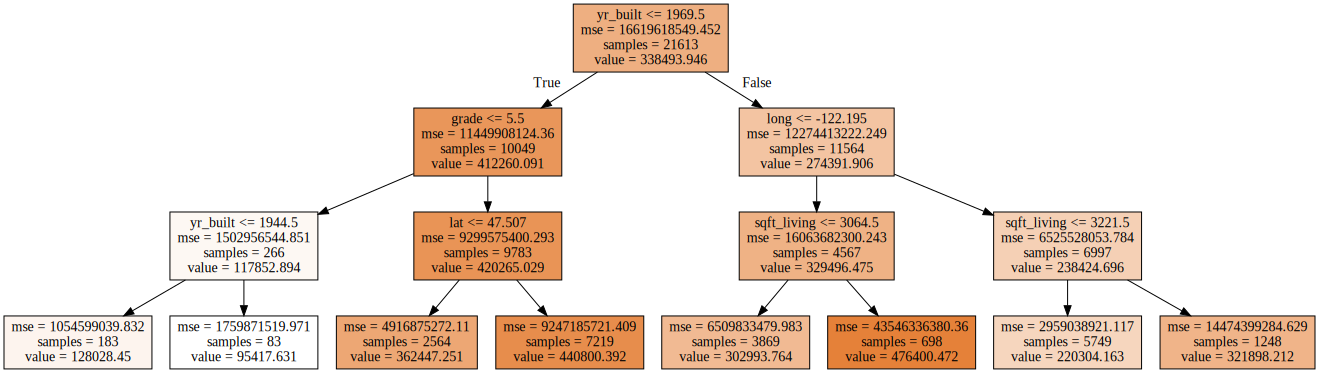

In [17]:
x, y = df_grade_increment.drop(target_name, axis=1), df_grade_increment[target_name]
dtree_exp = ssd.DecisionTreeExplain(x, y)
estimator = dtree_exp.dtree_reg_model(max_depth=3)
dtree_exp.visualize_dtree(estimator, 'grade_add_effect')

<font color='blue'>
    
Decision tree visualization: split criterion (gini)

top features to split: 
- yr_built
- grade
- long
- sqft_living

**Shapley values on 'grade'**

In [15]:
df_grade_shap = n_perturb.calc_perturb_shap_values()
shap_col = df_grade_shap.columns[-1]
df_grade_shap = pd.concat([house, df_grade_shap[[shap_col]]],axis=1)
df_grade_shap.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price,grade_shap_values
0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,221900.0,-85776.853728
1,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,538000.0,-88348.367237
2,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,180000.0,-119480.669920
3,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,604000.0,-81934.592962
4,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,510000.0,-9535.186511


In [16]:
df_grade_shap_effect = subgroup_discovery(df_grade_shap, perturb_attr, shap_col, ssd.IncrementalQFNumeric(1))
df_grade_shap_effect

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,68688.241542,sqft_living>=2730,4352.0,147164.721724,-5907.181385,-24.912850
1,66567.317247,sqft_living>=2730 AND yr_renovated: [0:1934[,4078.0,147340.873414,-5907.181385,-24.942670
2,66174.678744,sqft_living>=2730 AND waterfront=0,4260.0,143147.139032,-5907.181385,-24.232731
3,65345.166622,floors: [2.0:2.50[ AND sqft_living>=2730,3077.0,167276.612077,-5907.181385,-28.317501
4,65003.750111,bathrooms>=2.75 AND sqft_living>=2730,2405.0,188959.863168,-5907.181385,-31.988160
5,63028.466589,sqft_living>=2730 AND condition=3,3240.0,156880.584531,-5907.181385,-26.557604
6,59063.768824,sqft_living>=2730 AND sqft_lot>=12187,1749.0,201719.794083,-5907.181385,-34.148231
7,53174.054793,bathrooms>=2.75 AND floors: [2.0:2.50[,2403.0,153563.342178,-5907.181385,-25.996043
8,52727.890002,bedrooms: [4:5[ AND sqft_living>=2730,2375.0,153154.699046,-5907.181385,-25.926866
9,52182.908151,bathrooms>=2.75 AND sqft_lot>=12187,1172.0,218182.572455,-5907.181385,-36.935140


<font color='blue'>
    
First, we calculate the shapley values for `grade` feature

**shapley values is larger, which means in this single instance, `grade` contributes more to the final prediction of house price.** 

In the subgroup `sqft_living>=2730` or `sqft_living>=2730 AND yr_renovated: [0:1934[`, 'grade' has the largest impact, which indicates it pushes the house price prediction higher. Therefore, we could argue that in these subgroups, usually the house price is higher. 